In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
import missingno as msno
import pdb

In [67]:
king_county = pd.read_csv('./data/EXTR_RPSale.csv')

In [68]:
df_KC = pd.DataFrame(king_county)

In [69]:
df_KC.head()

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,PlatBlock,SellerName,BuyerName,PropertyType,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning
0,2324275,142205,9172,12/05/2007,650000,20071212001568,,,,,,,COLE VERN+JITKA ...,MINTON DAVID W+KIMBERLY A ...,3,6,3,N,N,N,N,1,8,
1,952729,278470,10,07/10/1987,0,198707130302,067,051,730140,P,"101-108,",,SEAFIRST MTG CORP ...,SEATTLE FIRST NATIONAL BANK ...,3,0,15,N,N,N,N,18,3,45
2,952729,278470,40,07/10/1987,0,198707130302,067,051,730140,P,"101-108,",,SEAFIRST MTG CORP ...,SEATTLE FIRST NATIONAL BANK ...,3,0,15,N,N,N,N,18,3,45
3,952729,278470,100,07/10/1987,0,198707130302,067,051,730140,P,"101-108,",,SEAFIRST MTG CORP ...,SEATTLE FIRST NATIONAL BANK ...,3,0,15,N,N,N,N,18,3,45
4,952729,278470,190,07/10/1987,0,198707130302,067,051,730140,P,"101-108,",,SEAFIRST MTG CORP ...,SEATTLE FIRST NATIONAL BANK ...,3,0,15,N,N,N,N,18,3,45


In [70]:
sales_price_dict = dict(df_KC.SalePrice.value_counts())
total = 0
for key, val in sales_price_dict.items():
    if key != 0:
        total += val
print("Total number of Sales Price > $0 = {}".format(total))
print("Total number of Sales Price = $0 = {}".format(sales_price_dict[0]))
print("Percentage of missing values = {}".format(sales_price_dict[0]/total))

Total number of Sales Price > $0 = 1337800
Total number of Sales Price = $0 = 706282
Percentage of missing values = 0.5279428913140978


In [71]:
kc_columns = list(df_KC.columns)
str_columns = ['DocumentDate', 'PlatType', 'PlatLot', 'SellerName', 'BuyerName', 'AFForestLand', 'AFCurrentUseLand', 'AFNonProfitUse', 'AFHistoricProperty']
[kc_columns.remove(x) for x in str_columns]
kc_int_columns = kc_columns
kc_str_columns = ['PlatType', 'PlatLot', 'SellerName', 'BuyerName', 'AFForestLand', 'AFCurrentUseLand', 'AFNonProfitUse', 'AFHistoricProperty']

In [72]:
df_KC = df_KC.applymap(lambda x: x.strip() if type(x) == str else x)

In [73]:
df_KC = df_KC.replace(to_replace='', value=np.nan)

In [74]:
df_KC.head()

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,PlatBlock,SellerName,BuyerName,PropertyType,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning
0,2324275,142205,9172,12/05/2007,650000,20071212001568,NaN,NaN,NaN,NaN,NaN,NaN,COLE VERN+JITKA,MINTON DAVID W+KIMBERLY A,3,6,3,N,N,N,N,1,8,NaN
1,952729,278470,10,07/10/1987,0,198707130302,067,051,730140,P,"101-108,",NaN,SEAFIRST MTG CORP,SEATTLE FIRST NATIONAL BANK,3,0,15,N,N,N,N,18,3,45
2,952729,278470,40,07/10/1987,0,198707130302,067,051,730140,P,"101-108,",NaN,SEAFIRST MTG CORP,SEATTLE FIRST NATIONAL BANK,3,0,15,N,N,N,N,18,3,45
3,952729,278470,100,07/10/1987,0,198707130302,067,051,730140,P,"101-108,",NaN,SEAFIRST MTG CORP,SEATTLE FIRST NATIONAL BANK,3,0,15,N,N,N,N,18,3,45
4,952729,278470,190,07/10/1987,0,198707130302,067,051,730140,P,"101-108,",NaN,SEAFIRST MTG CORP,SEATTLE FIRST NATIONAL BANK,3,0,15,N,N,N,N,18,3,45


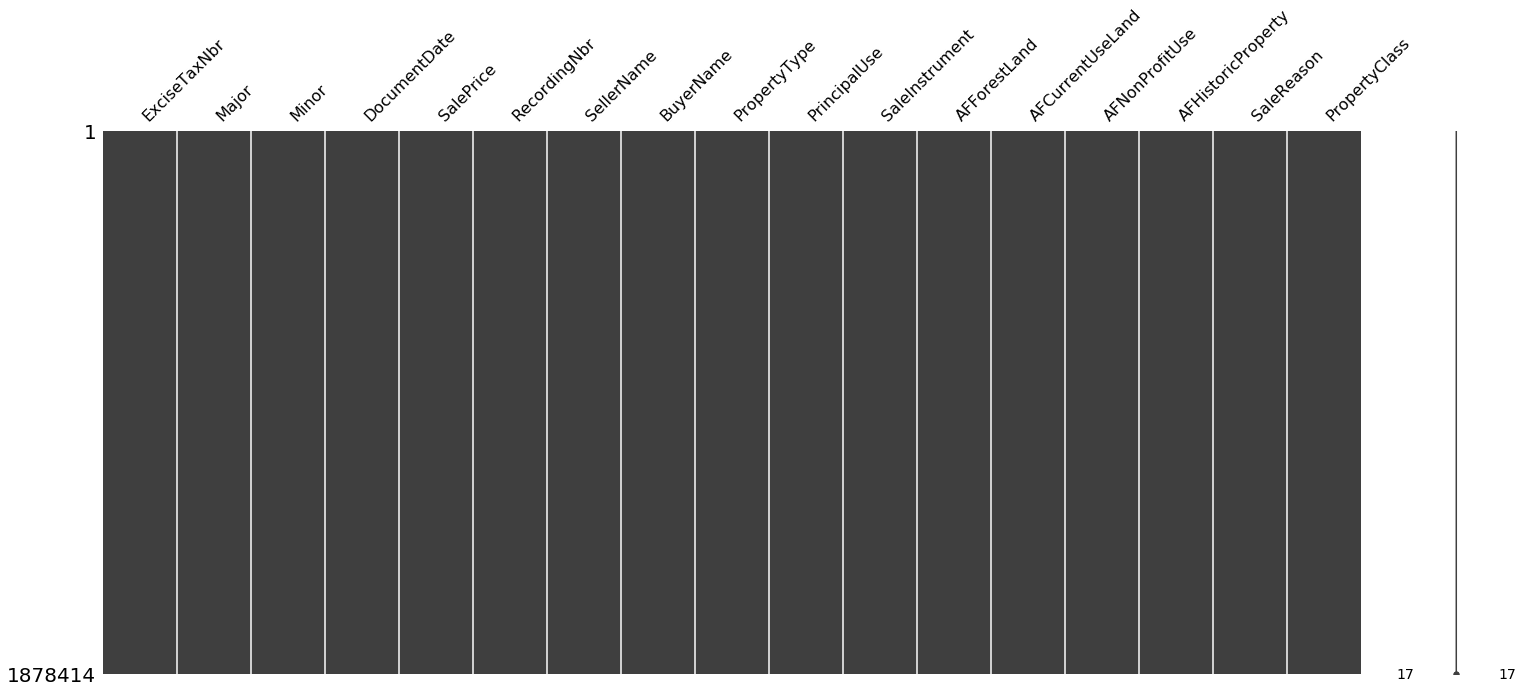

In [100]:
msno.matrix(df_KC)

In [80]:
df_KC = df_KC.dropna(axis=0,subset=['AFHistoricProperty'])

We dropped all missing values from the 'AFHistoricProperty' because we cannot replace with the mean or median values of categorical values.

In [101]:
df_KC.isna().sum()

ExciseTaxNbr          0
Major                 0
Minor                 0
DocumentDate          0
SalePrice             0
RecordingNbr          0
SellerName            0
BuyerName             0
PropertyType          0
PrincipalUse          0
SaleInstrument        0
AFForestLand          0
AFCurrentUseLand      0
AFNonProfitUse        0
AFHistoricProperty    0
SaleReason            0
PropertyClass         0
dtype: int64

In [83]:
df_KC = df_KC.dropna(axis=0,subset=['RecordingNbr'])

We can go ahead and drop all rows from a column with < 550 NA's

In [86]:
df_KC = df_KC.dropna(axis=0,subset=['Major','Minor','SellerName','BuyerName','AFForestLand','AFCurrentUseLand','AFNonProfitUse'])

In [90]:
13/18

0.7222222222222222

In [92]:
df_KC

P    0.824096
C    0.149738
U    0.024056
D    0.002110
Name: PlatType, dtype: float64

After analysis of the data, we concluded that we should not replace the NA's of columns that have 70% of it's data missing. We are going to drop those columns.

In [97]:
df_KC = df_KC.drop(axis=1,columns=['Volume','Page','PlatNbr','PlatType','PlatLot','PlatBlock','SaleWarning'])

In [99]:
df_KC.head()

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,SellerName,BuyerName,PropertyType,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass
0,2324275,142205,9172,12/05/2007,650000,20071212001568,COLE VERN+JITKA,MINTON DAVID W+KIMBERLY A,3,6,3,N,N,N,N,1,8
1,952729,278470,10,07/10/1987,0,198707130302,SEAFIRST MTG CORP,SEATTLE FIRST NATIONAL BANK,3,0,15,N,N,N,N,18,3
2,952729,278470,40,07/10/1987,0,198707130302,SEAFIRST MTG CORP,SEATTLE FIRST NATIONAL BANK,3,0,15,N,N,N,N,18,3
3,952729,278470,100,07/10/1987,0,198707130302,SEAFIRST MTG CORP,SEATTLE FIRST NATIONAL BANK,3,0,15,N,N,N,N,18,3
4,952729,278470,190,07/10/1987,0,198707130302,SEAFIRST MTG CORP,SEATTLE FIRST NATIONAL BANK,3,0,15,N,N,N,N,18,3


In [64]:
for column in kc_int_columns:
    df_KC[column] = df_KC[column].apply(int)

ValueError: invalid literal for int() with base 10: ''

In [30]:
# convert appropriate columns to int
# for column in kc_int_columns:
#     df_KC[column] = pd.to_numeric(df_KC[column], errors='raise')
df_KC.info()

ValueError: Unable to parse string "      " at position 946557

In [9]:
# convert appropriate columns to str
for column in kc_str_columns:
    df_KC[column] = df_KC[column].apply(str)

In [12]:
# convert DocumentDate column to datetime
df_KC['DocumentDate'] = pd.to_datetime(df_KC['DocumentDate'],errors='coerce')

KeyboardInterrupt: 

In [10]:
df_KC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2044082 entries, 0 to 2044081
Data columns (total 24 columns):
ExciseTaxNbr          float64
Major                 float64
Minor                 float64
DocumentDate          object
SalePrice             float64
RecordingNbr          float64
Volume                float64
Page                  float64
PlatNbr               float64
PlatType              object
PlatLot               object
PlatBlock             float64
SellerName            object
BuyerName             object
PropertyType          float64
PrincipalUse          float64
SaleInstrument        float64
AFForestLand          object
AFCurrentUseLand      object
AFNonProfitUse        object
AFHistoricProperty    object
SaleReason            float64
PropertyClass         float64
SaleWarning           float64
dtypes: float64(15), object(9)
memory usage: 374.3+ MB


In [11]:
df_KC.isnull().sum()

ExciseTaxNbr          2044082
Major                 2044082
Minor                 2044082
DocumentDate                0
SalePrice             2044082
RecordingNbr          2044082
Volume                2044082
Page                  2044082
PlatNbr               2044082
PlatType                    0
PlatLot                     0
PlatBlock             2044082
SellerName                  0
BuyerName                   0
PropertyType          2044082
PrincipalUse          2044082
SaleInstrument        2044082
AFForestLand                0
AFCurrentUseLand            0
AFNonProfitUse              0
AFHistoricProperty          0
SaleReason            2044082
PropertyClass         2044082
SaleWarning           2044082
dtype: int64

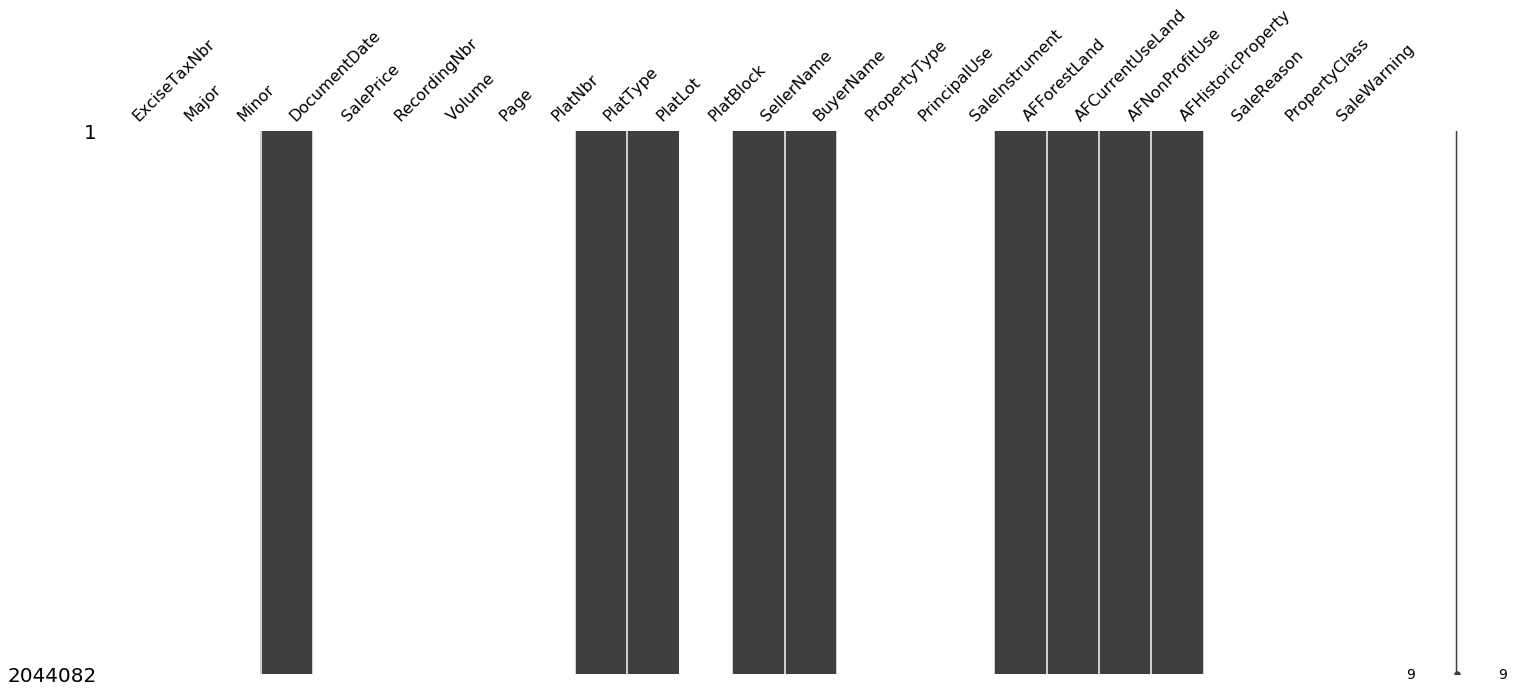

In [13]:
msno.matrix(df_KC)

In [ ]:
# correlation = df_KC.corr()
# plt.figure(figsize=(14,12))
# heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")